In [18]:
import os
import random
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     tf.random.set_seed(seed)
    tf.random.set_random_seed(1)


def hamiltonian_generator(N=32, c=4, normalize=False):
    # Returns a hamiltonian at N + 1 k-points, both 0 and 2 pi are included
    k = np.linspace(0, 2 * np.pi, N + 1)
    while True:
        coef = np.random.rand(c + 1, 4) * 2 - 1  # Fourier coefficients ax, bx, ay, by, [-1, 1]
        h = np.zeros((N + 1, 2))
        for i in range(coef.shape[0]):
            h[:, 0] += coef[i, 0] * np.cos(i * k) + coef[i, 1] * np.sin(i * k)
            h[:, 1] += coef[i, 2] * np.cos(i * k) + coef[i, 3] * np.sin(i * k)
        h_normalized = h / np.linalg.norm(h, axis=1, keepdims=True)
        args = np.angle(h_normalized[:-1, 0] + 1j * h_normalized[:-1, 1])
        arg_diff = (np.roll(args, -1) - args) % (2 * np.pi)
        indices = arg_diff >= np.pi
        arg_diff[indices] = arg_diff[indices] - 2 * np.pi  # Shift to [-pi, pi)
        w = -arg_diff.sum() / (2 * np.pi)
        w = np.round(w)
        yield (h_normalized, w) if normalize else (h, w)
        
def generate_data(size, dim_k, lower=0, upper=float('inf'), c=4):
    # generating data with specific winding numbers lower bound include upper bound not included
    X = np.zeros((size, dim_k, 2, 1))
    y = np.zeros(size)
    count = 0
    gen = hamiltonian_generator(dim_k - 1, c, normalize=True)
    while count < size:
        h, w = next(gen)
        if lower <= np.abs(w) < upper:
            X[count, :, :, 0] = h
            y[count] = w
            count += 1
    return X, y 
    

## Generate data

In [19]:
if os.path.exists('prl_data.npz'):
    with np.load('prl_data.npz') as f:
        X_train = f['X_train']
        y_train = f['y_train']
        X_test_1 = f['X_test_1']
        y_test_1 = f['y_test_1']
        X_test_3 = f['X_test_3']
        y_test_3 = f['y_test_3']
        X_test_4 = f['X_test_4']
        y_test_4 = f['y_test_4']
        train_size = X_train.shape[0]
        test_size = X_test_1.shape[0]
        dim_k = X_train.shape[1]
else:
    train_size = 10 ** 5
    test_size = 10 ** 4
    dim_k = 32 + 1
    X_train, y_train = generate_data(train_size, dim_k, 0, 3, c=4)  # Train data -2 <= w <= 2
    X_test_1, y_test_1 = generate_data(test_size, dim_k, 0, 3, c=4)  # Test data -2 <= w <= 2
    X_test_3, y_test_3 = generate_data(test_size, dim_k, 3, 4, c=6)  # Test data w = -3, 3
    X_test_4, y_test_4 = generate_data(test_size, dim_k, 4, 5, c=7)  # Test data w = -4, 4
    np.savez('prl_data.npz', X_train=X_train, y_train=y_train, X_test_1=X_test_1, y_test_1=y_test_1,
             X_test_3=X_test_3, y_test_3=y_test_3, X_test_4=X_test_4, y_test_4=y_test_4)
    
y_train = y_train.astype(int)
y_test_1 = y_test_1.astype(int)
y_test_3 = y_test_3.astype(int)
y_test_4 = y_test_4.astype(int)    

In [20]:
print( y_train[0] ) 

1


## Convolutional network

In [21]:
set_random_seeds()

model_cnn = Sequential()
model_cnn.add(Conv2D(filters=40, kernel_size=2, activation='relu', input_shape=(dim_k, 2, 1)))
model_cnn.add(Conv2D(filters=1, kernel_size=1, activation='relu'))

model_cnn.add(Flatten())
model_cnn.add(Dense(2, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 1, 40)         200       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 1, 1)          41        
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [22]:
batch_size = 50
num_epochs = 40
model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

Train on 100000 samples
Epoch 1/40
100000/100000 [==============================] - 6s 59us/sample - loss: 0.3764 - mean_absolute_error: 0.4527
Epoch 2/40
100000/100000 [==============================] - 6s 55us/sample - loss: 0.1168 - mean_absolute_error: 0.2669
Epoch 3/40
100000/100000 [==============================] - 6s 56us/sample - loss: 0.0870 - mean_absolute_error: 0.2287
Epoch 4/40
100000/100000 [==============================] - 5s 53us/sample - loss: 0.0728 - mean_absolute_error: 0.2055
Epoch 5/40
100000/100000 [==============================] - 5s 55us/sample - loss: 0.0641 - mean_absolute_error: 0.1908
Epoch 6/40
100000/100000 [==============================] - 5s 55us/sample - loss: 0.0573 - mean_absolute_error: 0.1797
Epoch 7/40
100000/100000 [==============================] - 5s 53us/sample - loss: 0.0518 - mean_absolute_error: 0.1695
Epoch 8/40
100000/100000 [==============================] - 5s 53us/sample - loss: 0.0466 - mean_absolute_error: 0.1591
Epoch 9/40
10000

In [23]:
# model_cnn.save('prl_cnn_model.h5')
history_cnn.history.keys()

dict_keys(['loss', 'mean_absolute_error'])

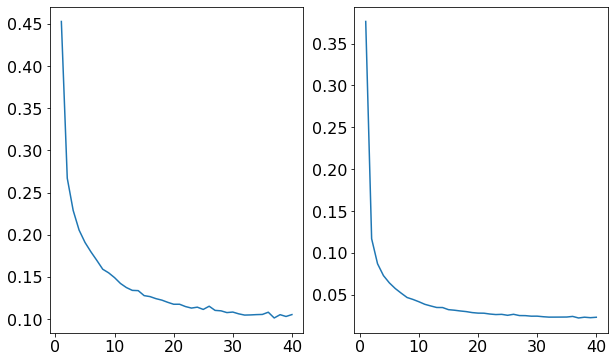

In [24]:
# mae_cnn = history_cnn.history['mae']
mae_cnn = history_cnn.history['mean_absolute_error']
loss_cnn = history_cnn.history['loss']

epochs = range(1, len(mae_cnn) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(epochs, mae_cnn)
axes[1].plot(epochs, loss_cnn)

In [25]:
cnn_train_pred = model_cnn.predict(X_train).flatten()
cnn_test_1_pred = model_cnn.predict(X_test_1).flatten()
cnn_test_3_pred = model_cnn.predict(X_test_3).flatten()
cnn_test_4_pred = model_cnn.predict(X_test_4).flatten()

print('train accuracy = {}'.format((y_train == cnn_train_pred.round()).sum() / len(y_train)))
print('test 1 accuracy = {}'.format((y_test_1 == cnn_test_1_pred.round()).sum() / len(y_test_1)))
print('test 3 accuracy = {}'.format((y_test_3 == cnn_test_3_pred.round()).sum() / len(y_test_3)))
print('test 4 accuracy = {}'.format((y_test_4 == cnn_test_4_pred.round()).sum() / len(y_test_4)))

train accuracy = 0.98075
test 1 accuracy = 0.9822
test 3 accuracy = 0.4968
test 4 accuracy = 0.4651
